**Description:** <br>
Here we try to predict the flight trajectory at the current timestep (can also be extended for future timesteps) for flights from ORY to TLS airports. The LSTM network has been trained on the flight data from ORY to TLS sorted by timestamps. In this version we set the number of time steps (lag) to be shifted (`n_in` >= **10**) in the `series_to_supervised` function and predict the latitude and longitude

* __Author__: Dilip Rajkumar

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=8, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.8g" % x))

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from math import sqrt

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [4]:
flightpaths = pd.read_csv('data/FlightsFromORYtoTLS_sorted.csv',parse_dates = ['postime'])
flightpaths.head()

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
0,2018-10-13 05:59:12,F-GKXE,3746532,48.729328,2.35702,0,31,0,0
1,2018-10-13 05:59:22,F-GKXE,3746532,48.729309,2.35701,0,212,0,0
2,2018-10-13 05:59:41,F-GKXE,3746532,48.729321,2.35702,0,128,0,0
3,2018-10-13 05:59:46,F-GKXE,3746532,48.729309,2.35702,0,131,0,0
4,2018-10-13 05:59:58,F-GKXE,3746532,48.729301,2.35701,0,247,0,0


In [5]:
# Check for Duplicates in the Dataframe
flightpaths[flightpaths.duplicated(subset=['postime','icao','lat','lon'])]

,postime,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed


In [6]:
# Check for Row values where we want to do the train-test split
flightpaths.iloc[6779]

postime          2018-10-13 18:49:33
aircraftreg                   F-HBNI
icao                         3769768
lat                          43.6292
lon                          1.37537
alt                                0
course                             8
speed                              2
verticalspeed                      0
Name: 6779, dtype: object

In [7]:
cols_of_interest = ['postime','aircraftreg','icao','lat','lon','alt','course','speed','verticalspeed']
flightpaths.set_index('postime',inplace = True)
flightpaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9739 entries, 2018-10-13 05:59:12 to 2018-10-13 06:19:22
Data columns (total 8 columns):
aircraftreg      9739 non-null object
icao             9739 non-null int64
lat              9739 non-null float64
lon              9739 non-null float64
alt              9739 non-null int64
course           9739 non-null int64
speed            9739 non-null int64
verticalspeed    9739 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 684.8+ KB


In [8]:
print("No. of Unique Airline Carriers flying from ORY to TLS:",flightpaths.aircraftreg.nunique())
print("No. of Unique ICAOs flying from ORY to TLS:",flightpaths.icao.nunique())

No. of Unique Airline Carriers flying from ORY to TLS: 12
No. of Unique ICAOs flying from ORY to TLS: 12


In [9]:
print("Unique ICAOs flying from ORY to TLS:",flightpaths.icao.unique(),"\n")
print("Unique Airline Carriers flying from ORY to TLS:",flightpaths.aircraftreg.unique())

Unique ICAOs flying from ORY to TLS: [3746532 3751299 3753188 3753192 3753697 3755023 3756228 3769765 3769768 3769770 4221197 4457132] 

Unique Airline Carriers flying from ORY to TLS: ['F-GKXE' 'F-GPMD' 'F-GRHE' 'F-GRHI' 'F-GRXB' 'F-GTAP' 'F-GUGE' 'F-HBNF' 'F-HBNI' 'F-HBNK' 'G-EZWL' 'OE-IJY']


In [10]:
# Check for Duplicates in the Dataframe
flightpaths[flightpaths.duplicated()]

,aircraftreg,icao,lat,lon,alt,course,speed,verticalspeed
postime,,,,,,,,
2018-10-13 06:10:40,F-GKXE,3746532,48.729340,2.35702,0,104,2,0
2018-10-13 06:16:02,F-GKXE,3746532,48.729401,2.35734,0,250,0,0
2018-10-13 06:17:48,F-GKXE,3746532,48.729271,2.35698,0,89,0,0
2018-10-13 06:25:59,F-GKXE,3746532,48.729309,2.35701,0,222,0,0
2018-10-13 06:29:05,F-GKXE,3746532,48.729321,2.35701,0,128,0,0
2018-10-13 06:29:30,F-GKXE,3746532,48.729321,2.35701,0,309,0,0
2018-10-13 06:30:15,F-GKXE,3746532,48.729321,2.35700,0,246,0,0
2018-10-13 06:30:35,F-GKXE,3746532,48.729321,2.35699,0,246,0,0
2018-10-13 06:32:50,F-GKXE,3746532,48.729321,2.35699,0,246,0,0


In [11]:
# flightpaths.drop_duplicates(keep='first', inplace=True)

### Data Pre-Processing and Feature Extraction:

In [12]:
# Drop Columns not needed for the neural network
flightpaths.drop(columns=['aircraftreg','icao'],inplace = True)
flightpaths.head()

,lat,lon,alt,course,speed,verticalspeed
postime,,,,,,
2018-10-13 05:59:12,48.729328,2.35702,0,31,0,0
2018-10-13 05:59:22,48.729309,2.35701,0,212,0,0
2018-10-13 05:59:41,48.729321,2.35702,0,128,0,0
2018-10-13 05:59:46,48.729309,2.35702,0,131,0,0
2018-10-13 05:59:58,48.729301,2.35701,0,247,0,0


In [13]:
# Check for NULL values across on column or row
flightpaths[flightpaths.isnull().any(axis=1)]

,lat,lon,alt,course,speed,verticalspeed
postime,,,,,,


In [14]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag (t-n) observations as input (X). Defaults to 1
        n_out: Number of lead (t + n) observations as output (y). Defaults to 1, that is var(t)
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Nomralizing the values before feeding into the neural network

In [15]:
# load dataset vales
values = flightpaths.values
# ensure all data is float
values = values.astype('float32')

# Set lag steps (n_in value) given as input attribute to series_to_supervised function
lag_steps = 10  
n_features = 6

# using Label encoder for any categorical variables
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [16]:
# Original flightpaths has 6 columns
values.shape

(9739, 6)

In [17]:
# do time step shifting to frame as supervised learning with scaled values
reframed = series_to_supervised(scaled_values, lag_steps, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[62,63,64,65]], axis=1, inplace=True)
reframed.head(10)

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),...,var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t)
10,0.997078,0.817607,0.0,0.084270,0.0,0.563291,0.997074,0.817600,0.0,0.592697,...,0.000000,0.563291,0.997073,0.817614,0.0,0.182584,0.000000,0.563291,0.997077,0.817607
11,0.997074,0.817600,0.0,0.592697,0.0,0.563291,0.997077,0.817607,0.0,0.356742,...,0.000000,0.563291,0.997077,0.817607,0.0,0.182584,0.000000,0.563291,0.997077,0.817614
12,0.997077,0.817607,0.0,0.356742,0.0,0.563291,0.997074,0.817607,0.0,0.365169,...,0.000000,0.563291,0.997077,0.817614,0.0,0.362360,0.000000,0.563291,0.997077,0.817614
13,0.997074,0.817607,0.0,0.365169,0.0,0.563291,0.997073,0.817600,0.0,0.691011,...,0.000000,0.563291,0.997077,0.817614,0.0,0.870787,0.000000,0.563291,0.997074,0.817607
14,0.997073,0.817600,0.0,0.691011,0.0,0.563291,0.997074,0.817600,0.0,0.691011,...,0.000000,0.563291,0.997074,0.817607,0.0,0.587079,0.000000,0.563291,0.997073,0.817600
15,0.997074,0.817600,0.0,0.691011,0.0,0.563291,0.997074,0.817600,0.0,0.865169,...,0.000000,0.563291,0.997073,0.817600,0.0,0.587079,0.000000,0.563291,0.997074,0.817635
16,0.997074,0.817600,0.0,0.865169,0.0,0.563291,0.997074,0.817594,0.0,0.865169,...,0.000000,0.563291,0.997074,0.817635,0.0,0.289326,0.004016,0.563291,0.997065,0.817754
17,0.997074,0.817594,0.0,0.865169,0.0,0.563291,0.997073,0.817607,0.0,0.356742,...,0.004016,0.563291,0.997065,0.817754,0.0,0.314607,0.000000,0.563291,0.997033,0.817719
18,0.997073,0.817607,0.0,0.356742,0.0,0.563291,0.997073,0.817614,0.0,0.182584,...,0.000000,0.563291,0.997033,0.817719,0.0,0.289326,0.004016,0.563291,0.997036,0.817719
19,0.997073,0.817614,0.0,0.182584,0.0,0.563291,0.997077,0.817607,0.0,0.182584,...,0.004016,0.563291,0.997036,0.817719,0.0,0.289326,0.004016,0.563291,0.997036,0.817726


In [18]:
# Manually defining split number equal last row of same flight and roughly split at 70%
train_test_split_row_nr = 6779

values = reframed.values

# split into train and test sets
train = values[:train_test_split_row_nr, :]
test = values[train_test_split_row_nr:, :]

# split into input and outputs - last two columns are the outputs
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], lag_steps, n_features))

In [19]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

In [19]:
%%time
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 6779 samples, validate on 2950 samples
Epoch 1/500
6779/6779 [==============================] - 7s 1ms/step - loss: 0.1608 - val_loss: 0.0965
Epoch 2/500
6779/6779 [==============================] - 2s 291us/step - loss: 0.0742 - val_loss: 0.0760
Epoch 3/500
6779/6779 [==============================] - 2s 281us/step - loss: 0.0667 - val_loss: 0.0417
Epoch 4/500
6779/6779 [==============================] - 2s 354us/step - loss: 0.0506 - val_loss: 0.0464
Epoch 5/500
6779/6779 [==============================] - 2s 328us/step - loss: 0.0491 - val_loss: 0.0305
Epoch 6/500
6779/6779 [==============================] - 2s 318us/step - loss: 0.0469 - val_loss: 0.0367
Epoch 7/500
6779/6779 [==============================] - 2s 331us/step - loss: 0.0480 - val_loss: 0.0379
Epoch 8/500
6779/6779 [==============================] - 2s 332us/step - loss: 0.0415 - val_loss: 0.0323
Epoch 9/500
6779/6779 [==============================] - 2s 325us/step - loss: 0.0417 - val_loss: 0.0204
Epoch 10/

Epoch 78/500
6779/6779 [==============================] - 1s 196us/step - loss: 0.0169 - val_loss: 0.0272
Epoch 79/500
6779/6779 [==============================] - 1s 187us/step - loss: 0.0176 - val_loss: 0.0115
Epoch 80/500
6779/6779 [==============================] - 1s 181us/step - loss: 0.0183 - val_loss: 0.0213
Epoch 81/500
6779/6779 [==============================] - 1s 191us/step - loss: 0.0139 - val_loss: 0.0194
Epoch 82/500
6779/6779 [==============================] - 1s 192us/step - loss: 0.0127 - val_loss: 0.0205
Epoch 83/500
6779/6779 [==============================] - 1s 185us/step - loss: 0.0164 - val_loss: 0.0123
Epoch 84/500
6779/6779 [==============================] - 1s 194us/step - loss: 0.0127 - val_loss: 0.0197
Epoch 85/500
6779/6779 [==============================] - 1s 188us/step - loss: 0.0179 - val_loss: 0.0125
Epoch 86/500
6779/6779 [==============================] - 1s 190us/step - loss: 0.0157 - val_loss: 0.0071
Epoch 87/500
6779/6779 [======================

Epoch 155/500
6779/6779 [==============================] - 1s 211us/step - loss: 0.0093 - val_loss: 0.0178
Epoch 156/500
6779/6779 [==============================] - 1s 217us/step - loss: 0.0128 - val_loss: 0.0126
Epoch 157/500
6779/6779 [==============================] - 1s 215us/step - loss: 0.0106 - val_loss: 0.0082
Epoch 158/500
6779/6779 [==============================] - 1s 212us/step - loss: 0.0092 - val_loss: 0.0140
Epoch 159/500
6779/6779 [==============================] - 1s 218us/step - loss: 0.0095 - val_loss: 0.0185
Epoch 160/500
6779/6779 [==============================] - 2s 221us/step - loss: 0.0119 - val_loss: 0.0107
Epoch 161/500
6779/6779 [==============================] - 1s 219us/step - loss: 0.0097 - val_loss: 0.0184
Epoch 162/500
6779/6779 [==============================] - 2s 223us/step - loss: 0.0111 - val_loss: 0.0126
Epoch 163/500
6779/6779 [==============================] - 2s 236us/step - loss: 0.0083 - val_loss: 0.0089
Epoch 164/500
6779/6779 [============

6779/6779 [==============================] - 1s 183us/step - loss: 0.0069 - val_loss: 0.0175
Epoch 308/500
6779/6779 [==============================] - 1s 184us/step - loss: 0.0086 - val_loss: 0.0077
Epoch 309/500
6779/6779 [==============================] - 1s 189us/step - loss: 0.0075 - val_loss: 0.0164
Epoch 310/500
6779/6779 [==============================] - 1s 205us/step - loss: 0.0078 - val_loss: 0.0100
Epoch 311/500
6779/6779 [==============================] - 1s 211us/step - loss: 0.0085 - val_loss: 0.0071
Epoch 312/500
6779/6779 [==============================] - 1s 182us/step - loss: 0.0064 - val_loss: 0.0061
Epoch 313/500
6779/6779 [==============================] - 1s 184us/step - loss: 0.0081 - val_loss: 0.0062
Epoch 314/500
6779/6779 [==============================] - 1s 190us/step - loss: 0.0082 - val_loss: 0.0131
Epoch 315/500
6779/6779 [==============================] - 1s 187us/step - loss: 0.0088 - val_loss: 0.0098
Epoch 316/500
6779/6779 [==========================

6779/6779 [==============================] - 2s 310us/step - loss: 0.0074 - val_loss: 0.0093
Epoch 460/500
6779/6779 [==============================] - 2s 327us/step - loss: 0.0088 - val_loss: 0.0057
Epoch 461/500
6779/6779 [==============================] - 2s 253us/step - loss: 0.0063 - val_loss: 0.0052
Epoch 462/500
6779/6779 [==============================] - 2s 271us/step - loss: 0.0052 - val_loss: 0.0089
Epoch 463/500
6779/6779 [==============================] - 2s 272us/step - loss: 0.0072 - val_loss: 0.0091
Epoch 464/500
6779/6779 [==============================] - 2s 298us/step - loss: 0.0079 - val_loss: 0.0090
Epoch 465/500
6779/6779 [==============================] - 2s 315us/step - loss: 0.0081 - val_loss: 0.0125
Epoch 466/500
6779/6779 [==============================] - 2s 314us/step - loss: 0.0076 - val_loss: 0.0102
Epoch 467/500
6779/6779 [==============================] - 2s 318us/step - loss: 0.0074 - val_loss: 0.0065
Epoch 468/500
6779/6779 [==========================

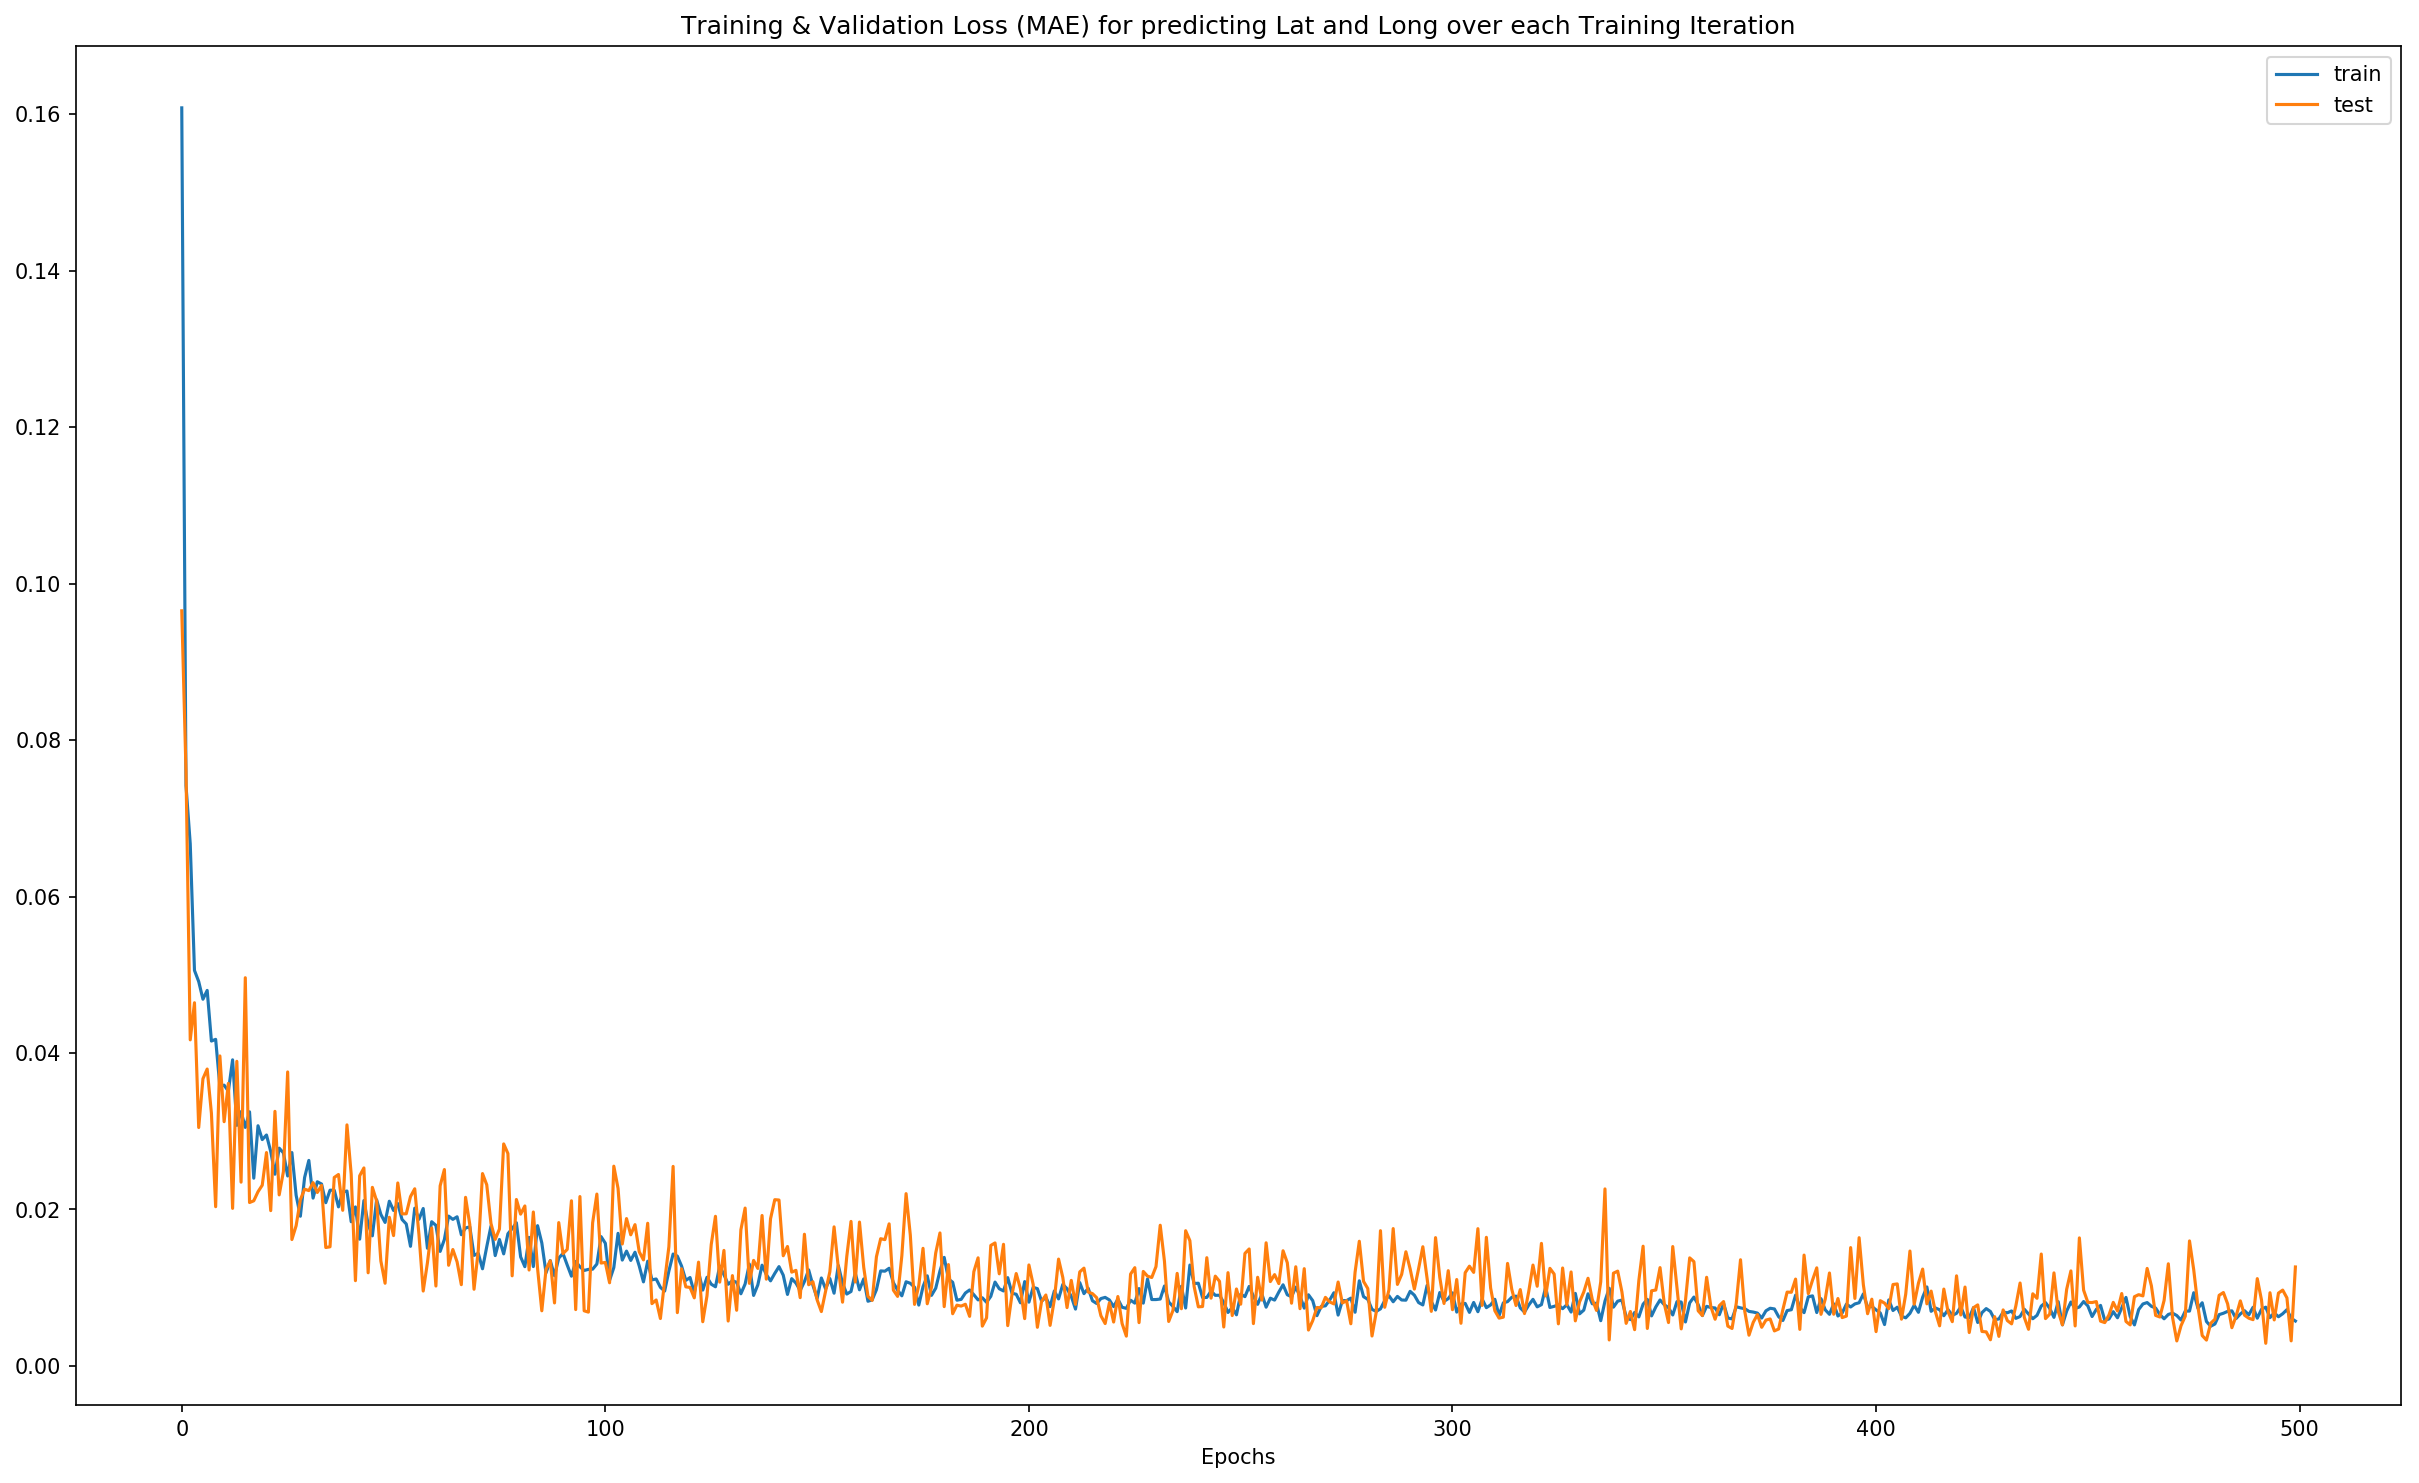

In [20]:
# plot history
plt.figure(figsize=(20,12),dpi=150)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Training & Validation Loss (MAE) for predicting Lat and Long over each Training Iteration')
plt.xlabel('Epochs')
plt.show()

In [21]:
# make a prediction
yhat = model.predict(test_X)
# Removing the timesteps from the 3D test input_data
test_X = test_X.reshape((test_X.shape[0],n_features*lag_steps))

# invert scaling for predicted values
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat_lat, inv_yhat_lon = inv_yhat[:,0], inv_yhat[:,1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 2))

inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)

inv_y = scaler.inverse_transform(inv_y)

inv_y_lat, inv_y_lon = inv_y[:,0], inv_y[:,1]

In [22]:
columns = ['Predicted_Latitude','Actual_Latitude','Predicted_Longitude','Actual_Longitude']
df_from_arr = pd.DataFrame(data=[inv_yhat_lat,inv_y_lat,inv_yhat_lon,inv_y_lon],index=columns).T
df_from_arr.head(10)

,Predicted_Latitude,Actual_Latitude,Predicted_Longitude,Actual_Longitude
0,48.648518,48.728523,2.344293,2.35668
1,48.653622,48.728523,2.344316,2.35669
2,48.653206,48.728523,2.344467,2.35668
3,48.652821,48.728512,2.342555,2.35669
4,48.653656,48.728512,2.344062,2.35668
5,48.657803,48.728512,2.345079,2.35667
6,48.656826,48.728512,2.342395,2.35667
7,48.650024,48.728535,2.340993,2.35665
8,48.657143,48.728523,2.343981,2.35667
9,48.655617,48.728523,2.344519,2.35668


In [23]:
df_from_arr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2950 entries, 0 to 2949
Data columns (total 4 columns):
Predicted_Latitude     2950 non-null float64
Actual_Latitude        2950 non-null float64
Predicted_Longitude    2950 non-null float64
Actual_Longitude       2950 non-null float64
dtypes: float64(4)
memory usage: 92.3 KB


In [24]:
# calculate RMSE
rmse_lat = sqrt(mean_squared_error(inv_y_lat, inv_yhat_lat))
print('Test RMSE for Latitude: %.3f' % rmse_lat)
# This looks high because lat values for these trajectories are higher than the longitude

Test RMSE for Latitude: 0.178


In [25]:
# calculate RMSE
rmse_lon = sqrt(mean_squared_error(inv_y_lon, inv_yhat_lon))
print('Test RMSE for Longitude: %.3f' % rmse_lon)

Test RMSE for Longitude: 0.036


### Observations:
* Increasing the lag steps (`n_in`) from 1 to 10 increased the training time per epoch but also results in better predictions and lower RMSE scores from the LSTM model.

In [46]:
flightpaths = pd.read_csv('data/FlightsFromORYtoTLS_sorted.csv',parse_dates = ['postime'])
flightpaths.drop(columns=['lat','lon'],inplace = True)
flightpaths=flightpaths[(train_test_split_row_nr + lag_steps):].reset_index(drop=True) # Not adding lag_steps will result in index length mismatch error in the next cell
flightpaths.head()

,postime,aircraftreg,icao,alt,course,speed,verticalspeed
0,2018-10-13 13:36:47,F-HBNK,3769770,0,180,0,0
1,2018-10-13 13:37:01,F-HBNK,3769770,0,180,0,0
2,2018-10-13 13:37:06,F-HBNK,3769770,0,271,0,0
3,2018-10-13 13:37:17,F-HBNK,3769770,0,89,0,0
4,2018-10-13 13:37:21,F-HBNK,3769770,0,89,0,0


In [27]:
df_from_arr['postime'] = flightpaths.postime.values
df_from_arr['icao'] = flightpaths.icao.values
df_from_arr['aircraftreg'] = flightpaths.aircraftreg.values

In [28]:
df_from_arr = df_from_arr[['postime','icao','aircraftreg','Predicted_Latitude','Predicted_Longitude','Actual_Latitude','Actual_Longitude']]
df_from_arr.head()

,postime,icao,aircraftreg,Predicted_Latitude,Predicted_Longitude,Actual_Latitude,Actual_Longitude
0,2018-10-13 13:36:47,3769770,F-HBNK,48.648518,2.344293,48.728523,2.35668
1,2018-10-13 13:37:01,3769770,F-HBNK,48.653622,2.344316,48.728523,2.35669
2,2018-10-13 13:37:06,3769770,F-HBNK,48.653206,2.344467,48.728523,2.35668
3,2018-10-13 13:37:17,3769770,F-HBNK,48.652821,2.342555,48.728512,2.35669
4,2018-10-13 13:37:21,3769770,F-HBNK,48.653656,2.344062,48.728512,2.35668


In [29]:
print("Unique Airline Carriers flying from ORY to TLS:",df_from_arr.aircraftreg.unique())

Unique Airline Carriers flying from ORY to TLS: ['F-HBNK' 'G-EZWL' 'OE-IJY']


In [30]:
print("Unique Airline icaos flying from ORY to TLS:",df_from_arr.icao.unique())

Unique Airline icaos flying from ORY to TLS: [3769770 4221197 4457132]


In [31]:
# Store each icao in separate dataframe
traj_icao1 = df_from_arr[df_from_arr.icao == 3769770]
traj_icao1.reset_index(drop = True, inplace = True)
traj_icao2 = df_from_arr[df_from_arr.icao == 4221197]
traj_icao2.reset_index(drop = True, inplace = True)
traj_icao3 = df_from_arr[df_from_arr.icao == 4457132]
traj_icao3.reset_index(drop = True, inplace = True)

In [32]:
traj_icao1.tail()

,postime,icao,aircraftreg,Predicted_Latitude,Predicted_Longitude,Actual_Latitude,Actual_Longitude
791,2018-10-13 14:52:05,3769770,F-HBNK,43.618469,1.369564,43.628891,1.37487
792,2018-10-13 14:52:11,3769770,F-HBNK,43.618935,1.369654,43.628891,1.37491
793,2018-10-13 14:54:04,3769770,F-HBNK,43.616680,1.369760,43.628891,1.37492
794,2018-10-13 14:54:09,3769770,F-HBNK,43.619892,1.370295,43.628902,1.37493
795,2018-10-13 14:59:39,3769770,F-HBNK,43.620056,1.370146,43.628902,1.37492


In [33]:
traj_icao2.tail()

,postime,icao,aircraftreg,Predicted_Latitude,Predicted_Longitude,Actual_Latitude,Actual_Longitude
1399,2018-10-13 19:28:19,4221197,G-EZWL,43.609802,1.367659,43.625362,1.37281
1400,2018-10-13 19:28:29,4221197,G-EZWL,43.608437,1.367611,43.625938,1.37264
1401,2018-10-13 19:28:30,4221197,G-EZWL,43.604416,1.363570,43.626019,1.37257
1402,2018-10-13 19:29:40,4221197,G-EZWL,43.606113,1.362173,43.629730,1.37222
1403,2018-10-13 19:29:47,4221197,G-EZWL,43.618824,1.365673,43.629932,1.37259


In [34]:
traj_icao3.tail()

,postime,icao,aircraftreg,Predicted_Latitude,Predicted_Longitude,Actual_Latitude,Actual_Longitude
745,2018-10-13 06:17:56,4457132,OE-IJY,43.608704,1.361836,43.627281,1.37124
746,2018-10-13 06:18:02,4457132,OE-IJY,43.608513,1.361508,43.627560,1.37093
747,2018-10-13 06:19:01,4457132,OE-IJY,43.608261,1.361214,43.629578,1.37286
748,2018-10-13 06:19:17,4457132,OE-IJY,43.616077,1.366663,43.629856,1.37323
749,2018-10-13 06:19:22,4457132,OE-IJY,43.621433,1.369368,43.629890,1.37325


In [35]:
# Extract Lat and Long trajectories of every flight
# icao1
predicted_latitude_icao1 = traj_icao1.Predicted_Latitude.values
predicted_longitude_icao1 = traj_icao1.Predicted_Longitude.values
actual_latitude_icao1 = traj_icao1.Actual_Latitude.values
actual_longitude_icao1 = traj_icao1.Actual_Longitude.values
# icao2
predicted_latitude_icao2 = traj_icao2.Predicted_Latitude.values
predicted_longitude_icao2 = traj_icao2.Predicted_Longitude.values
actual_latitude_icao2 = traj_icao2.Actual_Latitude.values
actual_longitude_icao2 = traj_icao2.Actual_Longitude.values
# icao3
predicted_latitude_icao3 = traj_icao3.Predicted_Latitude.values
predicted_longitude_icao3 = traj_icao3.Predicted_Longitude.values
actual_latitude_icao3 = traj_icao3.Actual_Latitude.values
actual_longitude_icao3 = traj_icao3.Actual_Longitude.values

#### Plot Predicted and Actual Trajectories

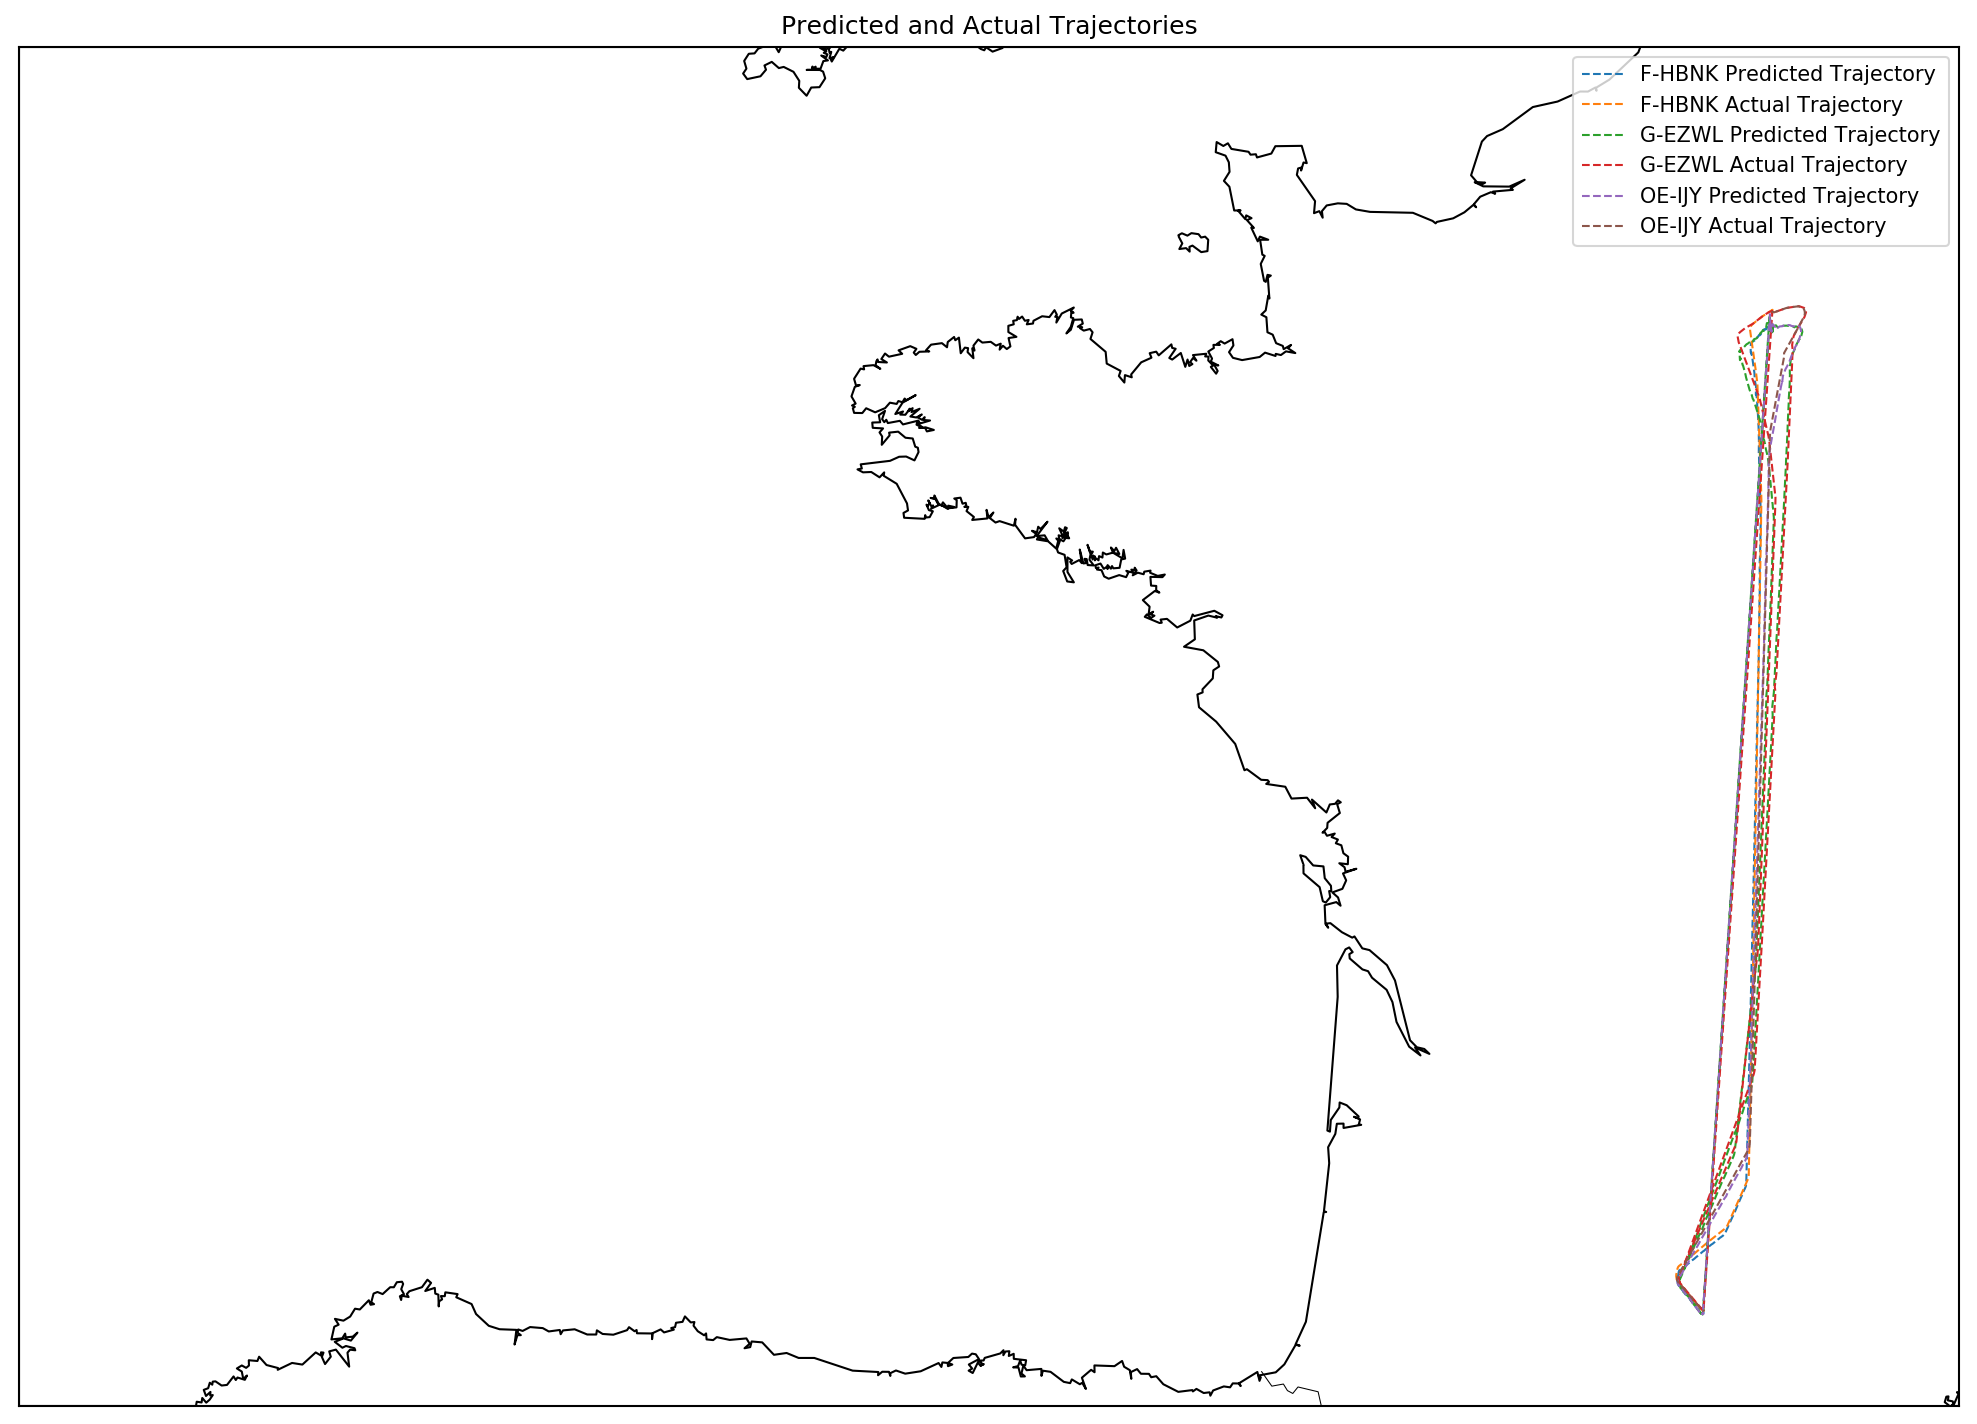

In [36]:
# resolution = "i" requires basemap-data-hires library else set resolution = "l"
fig = plt.figure(figsize=(20,12),dpi=150)
m = Basemap(projection='tmerc',llcrnrlon=-10.5,llcrnrlat=43,urcrnrlon=4.,urcrnrlat=50.,resolution='i',lat_0 = 39.5, lon_0 = -3.25)

x1, y1 = m(predicted_longitude_icao1, predicted_latitude_icao1)
x2, y2 = m(actual_longitude_icao1, actual_latitude_icao1)
x3, y3 = m(predicted_longitude_icao2, predicted_latitude_icao2)
x4, y4 = m(actual_longitude_icao2, actual_latitude_icao2)
x5, y5 = m(predicted_longitude_icao3, predicted_latitude_icao3)
x6, y6 = m(actual_longitude_icao3, actual_latitude_icao3)

## Specify Custom colors for each line plot
# m.plot(x1, y1, '--', markersize=0.1, linewidth=1, color = "green", label = 'F-HBNK Predicted Trajectory') 
# m.plot(x2, y2, '--', markersize=0.1, linewidth=1, color = "blue", label = 'F-HBNK Actual Trajectory') 
# m.plot(x3, y3, '--', markersize=0.1, linewidth=1, color = "orange", label = 'G-EZWL Predicted Trajectory') 
# m.plot(x4, y4, '--', markersize=0.1, linewidth=1, color = "red", label = 'G-EZWL Actual Trajectory') 
# m.plot(x5, y5, '--', markersize=0.1, linewidth=1, color = "yellow", label = 'OE-IJY Predicted Trajectory') 
# m.plot(x6, y6, '--', markersize=0.1, linewidth=1, color = "aqua", label = 'OE-IJY Actual Trajectory') 

m.plot(x1, y1, '--', markersize=0.1, linewidth=1,label = 'F-HBNK Predicted Trajectory') 
m.plot(x2, y2, '--', markersize=0.1, linewidth=1,label = 'F-HBNK Actual Trajectory') 
m.plot(x3, y3, '--', markersize=0.1, linewidth=1,label = 'G-EZWL Predicted Trajectory') 
m.plot(x4, y4, '--', markersize=0.1, linewidth=1,label = 'G-EZWL Actual Trajectory') 
m.plot(x5, y5, '--', markersize=0.1, linewidth=1,label = 'OE-IJY Predicted Trajectory') 
m.plot(x6, y6, '--', markersize=0.1, linewidth=1,label = 'OE-IJY Actual Trajectory') 

m.drawcoastlines()
m.fillcontinents(color='white')
m.drawmapboundary(fill_color='white')
m.drawstates(color='black')
m.drawcountries(color='black')
plt.legend()
plt.title("Predicted and Actual Trajectories")
plt.show() 

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=398682.13055362017,4851587.100659429,1571686.3866241965,5540758.787687671&bboxSR=5520&imageSR=5520&size=1500,881&dpi=96&format=png32&transparent=true&f=image


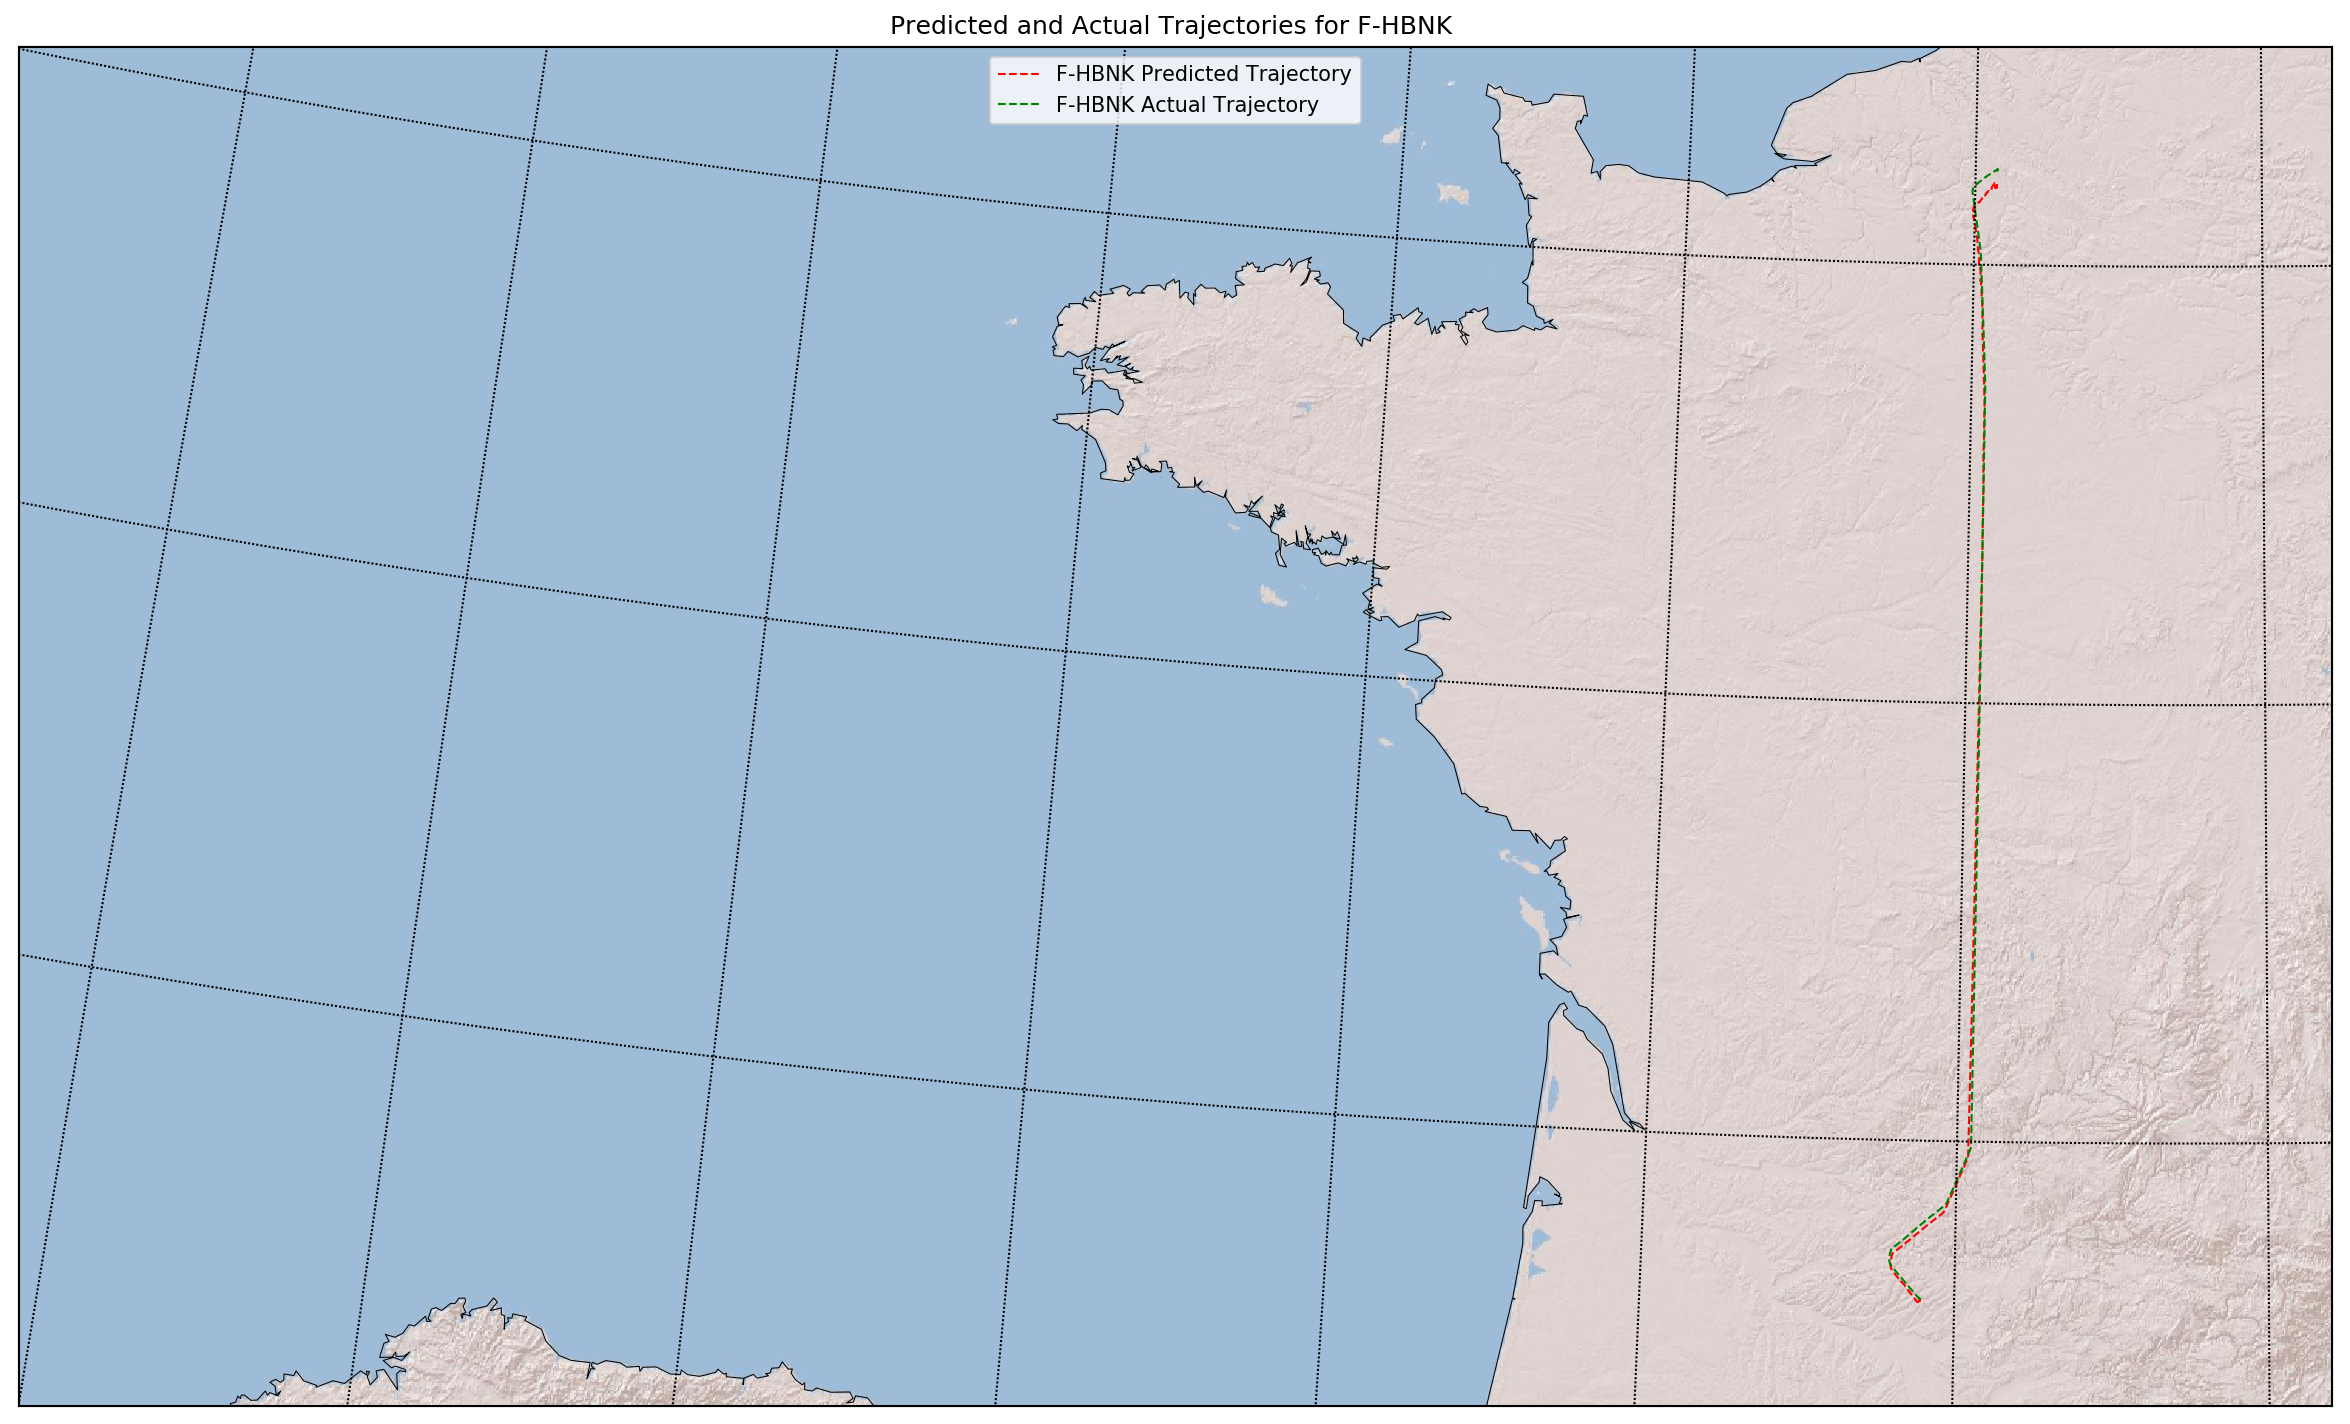

In [37]:
fig = plt.figure(figsize=(20,12),dpi=150)

m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=50.0,llcrnrlon=-10.5, urcrnrlon=4.0,resolution='i', area_thresh=1000,epsg=5520)

## Use various Background Map Images
# m.bluemarble()
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True) #PhotoRealistic Satellite Images
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True)


m.plot(x1, y1, '--', markersize=0.1, linewidth=1,label = 'F-HBNK Predicted Trajectory',color = "red") 
m.plot(x2, y2, '--', markersize=0.1, linewidth=1,label = 'F-HBNK Actual Trajectory',   color = "green") 
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)

# Draw parallels and meridians
m.drawparallels(np.arange(43,50,2.0))
m.drawmeridians(np.arange(-10.5,4.0,2.0))
m.drawmapboundary(fill_color=None)
plt.legend()
plt.title("Predicted and Actual Trajectories for F-HBNK ")
plt.show() 